Intro

Text documents are one of the richest sources of data for businesses.

We’ll use a public dataset from the BBC comprised of 2225 articles, each labeled under one of 5 categories: business, entertainment, politics, sport or tech.

The dataset is broken into 1490 records for training and 735 for testing. The goal will be to build a system that can accurately classify previously unseen news articles into the right category.

The competition is evaluated using Accuracy as a metric.

Purpose

The purpose of this analysis is to build a model to accurately classify news articles into the correct category for submission for the kaggle competition. A secondary goal is to help me further my understanding of machine learning. We will be using a NMF model that then feeds into a Regression Model to classify the texts into one of the 5 categories.

Data:

The data can be found on kaggle here: https://www.kaggle.com/c/learn-ai-bbc/data

File descriptions
BBC News Train.csv - the training set of 1490 records
BBC News Test.csv - the test set of 736 records
BBC News Sample Solution.csv - a sample submission file in the correct format
Data fields
ArticleId - Article id unique # given to the record
Article - text of the header and article
Category - cateogry of the article (tech, business, sport, entertainment, politics/li>

In [65]:
! pip3.9 install seaborn

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [31]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression

EDA

I begin the analysis by doing some exploration. First, I perform some cursory examination by viewing some rows from the dataset as well as observing the data types of the columns. Note that there seems to be no null rows as all 1490 rows in the training dataset has values. I also view a single text column in its entirety to get a better understanding of the data to be processed.

Next we move on to some visualizations of the data. I start by plotting out the distributions of the dataset by the category they have been labeled with. Note that it seems the dataset has a good balance between all the categories. I then plot out the distribution of the dataset based on the word length of the text column. Most of the texts seem to be in the 400-700 word range with a few outliers that have over a 1000 words. I decide to keep these I believe the model should be able to handle articles of larger lengths and not just short articles. Finally, I plot out a word cloud to see the most common characters in the dataset as well as plot out the wordcloud split by category. One thing I immediately notice is that stop words like "the", "and" etc are the most common. These should be removed before begin our modeling.

Plan after EDA
1. Preprocess the data. Based on the EDA it seems there are lots of stop words that should be removed. I also note some other common preprocessing that should be done for Natural Language Processing tasks like removing special characters/punctuation, lowercasing, stemming and tokenizng. I will go more into detail in the data preprocessing step.
2. Use a NMF model. NMF models are good for topic modeling since NMF can decompose the TF-IDF matrix into two non-negative matrices. One for the documents and one for the topics. Each document is represnted by a linear combination of topics while each topic is a linear combination of words. This allows NMF to automatically extract meaningful topics from text data and is perfect for this task
3. Use a Regression model to do the classification after using NMF to collect the features. 

In [12]:
train_data = pd.read_csv('learn-ai-bbc/BBC News Train.csv')
test_data = pd.read_csv('learn-ai-bbc/BBC News Test.csv')

print(train_data.head())
print(test_data.head())
print(train_data.info())
print(test_data.info())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     -----------

In [15]:
print(train_data.iloc[1]['Text'])

german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.6

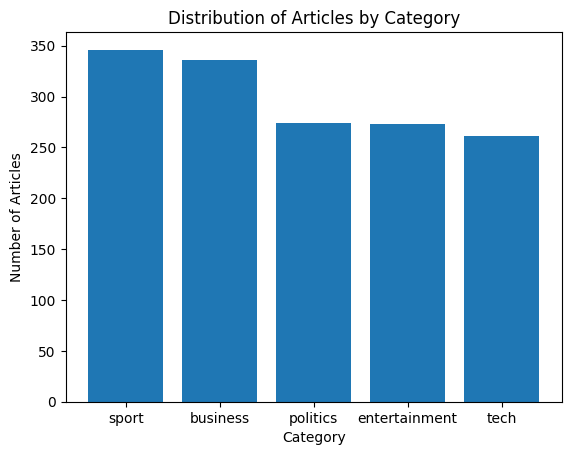

In [16]:
import matplotlib.pyplot as plt

# Assuming train_data is your DataFrame
category_counts = train_data['Category'].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of Articles by Category')
plt.show()

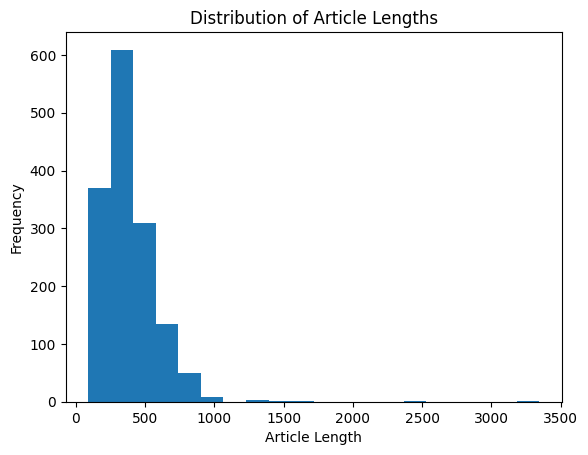

In [20]:
# Calculate article lengths
train_data['Article Length'] = train_data['Text'].apply(lambda x: len(x.split()))

# Plot the distribution of article lengths
plt.hist(train_data['Article Length'], bins=20)
plt.xlabel('Article Length')
plt.ylabel('Frequency')
plt.title('Distribution of Article Lengths')
plt.show()

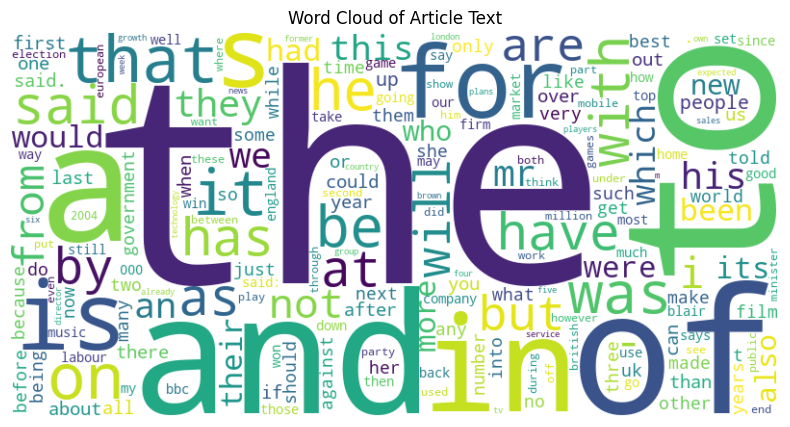

In [19]:
from collections import Counter
from wordcloud import WordCloud

# Combine all text into a single string
all_text = ' '.join(train_data['Text'])

# Tokenize the text and count word frequencies
words = all_text.split()
word_freq = Counter(words)

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Article Text')
plt.show()

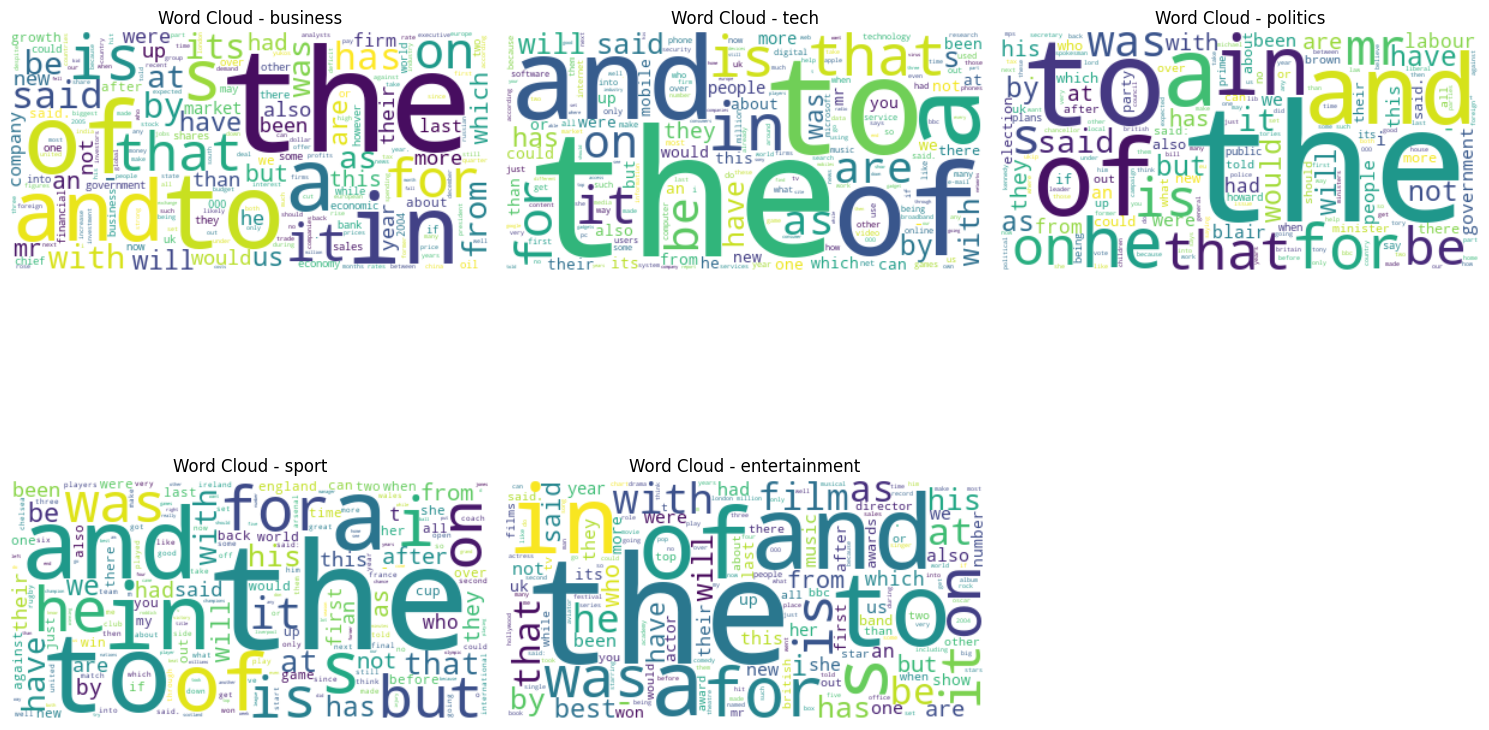

In [21]:
# Calculate word frequencies for each category
word_freq_by_category = {}
for category in train_data['Category'].unique():
    category_text = ' '.join(train_data[train_data['Category'] == category]['Text'])
    words = category_text.split()
    word_freq_by_category[category] = Counter(words)

# Plot word clouds for each category
plt.figure(figsize=(15, 10))
for i, (category, word_freq) in enumerate(word_freq_by_category.items(), 1):
    plt.subplot(2, 3, i)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {category}')
plt.tight_layout()
plt.show()

Data preprocessing:

As mentioned in the EDA, we will be doing the following preprocessing of the data:

1. Lowercasing
2. Removing Punctuation and Special Characters
3. Removing Stopwords
4. Stemming or Lemmatization (reduce words to root words to get all variations of the word)
5. Tokenization

This will help the model perform much better since it does not need to worry about a lot of the edge cases that are solved by the steps above.

After I perform these data preprocessing, I draw the word clouds by category again and we see that there is a much more meaningful word cloud with useful words sorted by category.

In [27]:
train_data['Text'] = train_data['Text'].str.lower()

import nltk
nltk.download('punkt')

import string

train_data['Text'] = train_data['Text'].str.replace('[{}]'.format(string.punctuation), '')

nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))
train_data['Text'] = train_data['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
train_data['Text'] = train_data['Text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

train_data['Tokenized Text'] = train_data['Text'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /Users/tonyzhan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tonyzhan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


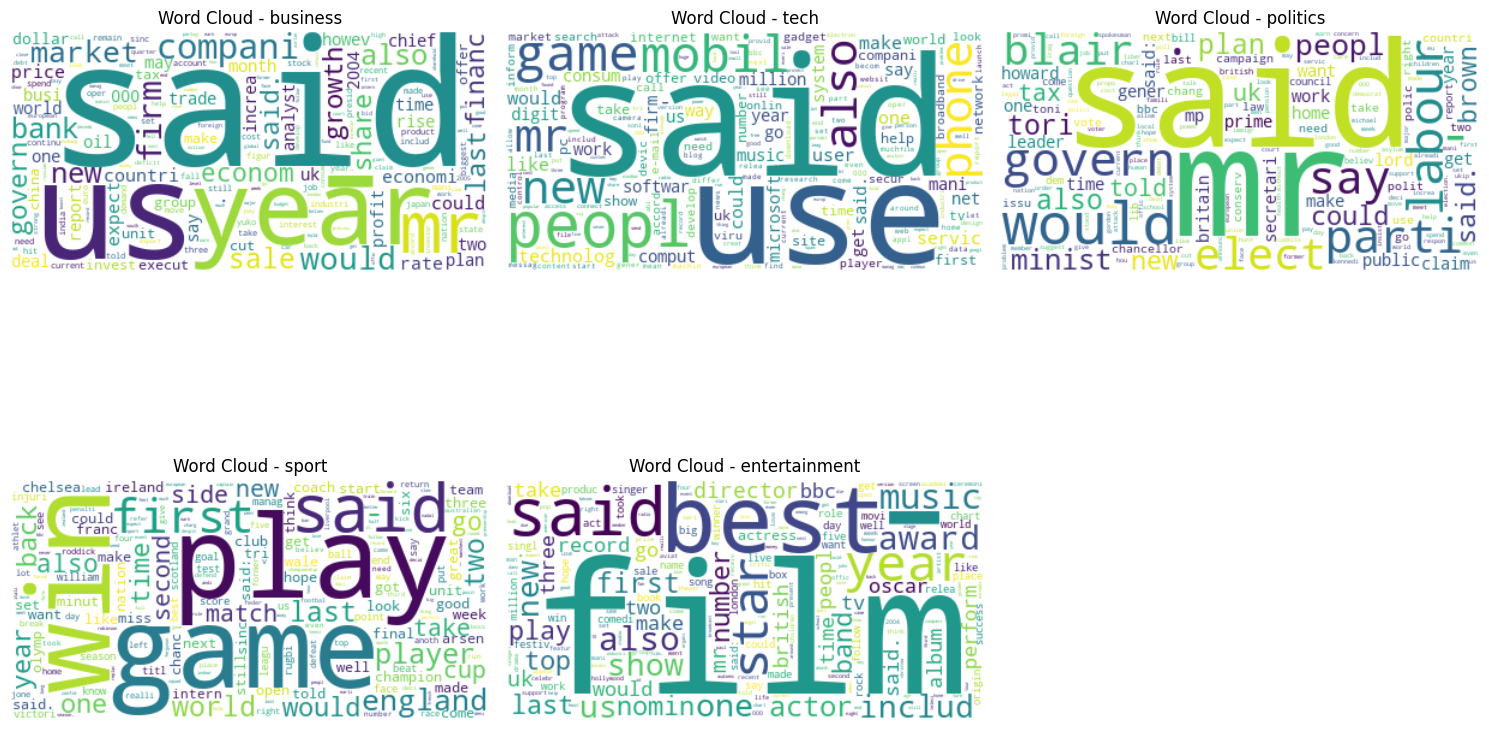

In [28]:
# Calculate word frequencies for each category
word_freq_by_category = {}
for category in train_data['Category'].unique():
    category_text = ' '.join(train_data[train_data['Category'] == category]['Text'])
    words = category_text.split()
    word_freq_by_category[category] = Counter(words)

# Plot word clouds for each category
plt.figure(figsize=(15, 10))
for i, (category, word_freq) in enumerate(word_freq_by_category.items(), 1):
    plt.subplot(2, 3, i)
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(word_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud - {category}')
plt.tight_layout()
plt.show()

In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ArticleId       1490 non-null   int64 
 1   Text            1490 non-null   object
 2   Category        1490 non-null   object
 3   Article Length  1490 non-null   int64 
 4   Tokenized Text  1490 non-null   object
dtypes: int64(2), object(3)
memory usage: 58.3+ KB


Model

As mentioned before, we will use a NMF model to grab the topics from the text. NMF models are good for topic modeling since NMF can decompose the TF-IDF matrix into two non-negative matrices. One for the documents and one for the topics. Each document is represnted by a linear combination of topics while each topic is a linear combination of words. This allows NMF to automatically extract meaningful topics from text data and is perfect for this task

To achieve this my model will have the following architecture:
1. TF-IDF vectorize the text into a matrix
2. NMF model on the matrix to split it into two non-negative matricies
3. Regression classification model using the NMF model to do the final classification task

The main hyperparameters I will be adjust are: 

TF-IDF:
min_df=2
max_df=0.9

NMF
n_components=5
l1_ratio=0.5
beta_loss='kullback-leibler'

min_df: This parameter specifies the minimum document frequency for a word to be included in the vocabulary. If a word occurs in fewer than min_df documents, it will be ignored. Setting min_df helps filter out words that are too rare to be informative.

max_df: This parameter specifies the maximum document frequency for a word to be included in the vocabulary. If a word occurs in more than max_df fraction of the documents, it will be ignored. Setting max_df helps filter out words that are too common and may not be informative

n_components: Specifies the number of latent topics to be extracted from the TF-IDF representation. This parameter controls the dimensionality of the topic space and influences the interpretability of the extracted topics.

l1_ratio: This parameter controls the regularization strength in NMF. The default value is 0.0, indicating no regularization (i.e., only L2 regularization). Setting l1_ratio to values between 0 and 1 introduces a combination of L1 and L2 regularization, where higher values favor sparser solutions. Experimenting with different values of l1_ratio can help in controlling model complexity and avoiding overfitting.

beta_loss: This parameter determines the loss function used for NMF. The default value is 'frobenius', which corresponds to the Frobenius norm. Other options include 'kullback-leibler', which measures the divergence between the input matrix and the reconstructed matrix using the Kullback-Leibler divergence. The only values I test are frobenius and kullback-leibler.

Hyperparameter Tuning

I just went through an iterative process of changing the hyperparameters and viewing the printed out evaluation metrics I have: Validation Accuracy, Precision, Recall, F1-score, Confusion Matrix. I usually adjust one hyperparameter at a time and based on the evaluation metrics I will adjust accordingly.

Here are my hyperparameter test results:

1--------------------------------------------------

hyperparameters:

min_df=0.0
max_df=0.99

n_components=5
l1_ratio=0
beta_loss='frobenius'

results:

Validation Accuracy: 0.9082774049217002
Precision: 0.9136794240847232
Recall: 0.9082774049217002
F1-score: 0.9070185198753162
Confusion Matrix:
[[105   0   1   0   2]
 [  3  62   1  11   2]
 [  4   0  77   3   2]
 [  0   0   0 101   0]
 [  5   2   1   4  61]]

2--------------------------------------------------

beta_loss changed to kullback-leibler

hyperparameters:

min_df=0.0
max_df=0.99

n_components=5
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9619686800894854
Precision: 0.9623948340699158
Recall: 0.9619686800894854
F1-score: 0.9619148360828446
Confusion Matrix:
[[104   0   2   0   2]
 [  1  74   0   2   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]

3--------------------------------------------------

increase min_df to 2

hyperparameters:

min_df=2
max_df=0.99

n_components=5
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9686800894854586
Precision: 0.9689142315895876
Recall: 0.9686800894854586
F1-score: 0.9686517274087268
Confusion Matrix:
[[105   0   2   0   1]
 [  0  76   0   1   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]

4--------------------------------------------------

increase min_df to 5

hyperparameters:

min_df=5
max_df=0.99

n_components=5
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9574944071588367
Precision: 0.9589702107818208
Recall: 0.9574944071588367
F1-score: 0.9576971619304311
Confusion Matrix:
[[105   0   2   0   1]
 [  0  75   1   1   2]
 [  3   0  83   0   0]
 [  0   0   2  99   0]
 [  2   0   5   0  66]]

5--------------------------------------------------

decrease max_df to 0.9. min_df back to 2
(results in no difference from test 3)

hyperparameters:

min_df=2
max_df=0.9

n_components=5
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9686800894854586
Precision: 0.9689142315895876
Recall: 0.9686800894854586
F1-score: 0.9686517274087268
Confusion Matrix:
[[105   0   2   0   1]
 [  0  76   0   1   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]

6--------------------------------------------------

n_components increased to 10.

hyperparameters:

min_df=2
max_df=0.9

n_components=10
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9530201342281879
Precision: 0.9529929392633538
Recall: 0.9530201342281879
F1-score: 0.9528219781512619
Confusion Matrix:
[[101   0   1   2   4]
 [  0  77   0   1   1]
 [  3   0  81   2   0]
 [  0   0   0 101   0]
 [  2   1   4   0  66]]

7--------------------------------------------------

n_components decreased to 3.

hyperparameters:

min_df=2
max_df=0.9

n_components=3
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.6577181208053692
Precision: 0.573939517915088
Recall: 0.6577181208053692
F1-score: 0.5679889666642128
Confusion Matrix:
[[ 96   0   8   0   4]
 [  6   0   0  73   0]
 [  3   0  82   1   0]
 [  0   0   0 101   0]
 [ 55   0   3   0  15]]

7--------------------------------------------------

n_components back to 5. l1_ratio to 0.5
(results in no difference from test 3)

hyperparameters:

min_df=2
max_df=0.9

n_components=3
l1_ratio=0.5
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9686800894854586
Precision: 0.9689142315895876
Recall: 0.9686800894854586
F1-score: 0.9686517274087268
Confusion Matrix:
[[105   0   2   0   1]
 [  0  76   0   1   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]

Analysis of Results

Based on my iterative testing, the best results I had were with the following hyperparameters:
min_df=2
max_df=0.9

n_components=5
l1_ratio=0.5
beta_loss='kullback-leibler'

I noticed that changing beta_loss from "frobenius" to "kullback-leibler" made the biggest impact on the accuracy of the model. This makes sense as these two loss functions are more effective at different tasks. KL divergence is well-suited for tasks where the data distribution is non-negative and inherently sparse. It is particularly effective when the data has a Poisson-like distribution or when modeling probabilistic distributions. KL divergence is commonly used in text mining tasks such as topic modeling, where the goal is to extract latent topics from text data while maintaining sparsity and interpretability. Frobenius norm is more suitable for tasks where the data distribution is non-negative but not necessarily sparse. It is commonly used in tasks where the goal is to find a low-rank approximation of the data matrix. Frobenius norm is often used in tasks such as image processing, audio analysis, and recommender systems, where the goal is to approximate a high-dimensional data matrix with a low-rank factorization.

Other hyperparameters made a difference but only slightly. Mainly changing min_df to 2 increased the performance. Increasing it further to 5 decreased performance as it probably started to overfit the data. max_df did not make any noticeable difference. n_components at 5 was optimal and and changes caused decrease in accuracy of the model. l1_ratio did not noticeably change the accuracy of the model.

In [61]:
# Split the original text data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data['Text'], train_data['Category'], test_size=0.3, random_state=42)

# hyperparameters
min_df=2
max_df=0.9

n_components=5
l1_ratio=0.5
beta_loss='kullback-leibler' # or frobenius

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(min_df = min_df,
                          max_df = max_df,
                          stop_words = 'english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

# Initialize NMF model
nmf_model = NMF(n_components=n_components,
                l1_ratio = l1_ratio,
                beta_loss = beta_loss,
                solver='mu',
                random_state=42)

# Fit the NMF model to the training data
X_train_nmf = nmf_model.fit_transform(X_train_tfidf)
X_val_nmf = nmf_model.transform(X_val_tfidf)

# Train a classifier on the transformed training data
classifier = LogisticRegression()
classifier.fit(X_train_nmf, y_train)

# Predict on the validation data
y_pred_val = classifier.predict(X_val_nmf)

In [62]:
# Evaluate the model performance on the validation set
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)

# Compute precision, recall, and F1-score
precision = precision_score(y_val, y_pred_val, average='weighted')
recall = recall_score(y_val, y_pred_val, average='weighted')
f1 = f1_score(y_val, y_pred_val, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

Validation Accuracy: 0.9686800894854586
Precision: 0.9689142315895876
Recall: 0.9686800894854586
F1-score: 0.9686517274087268
Confusion Matrix:
[[105   0   2   0   1]
 [  0  76   0   1   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]


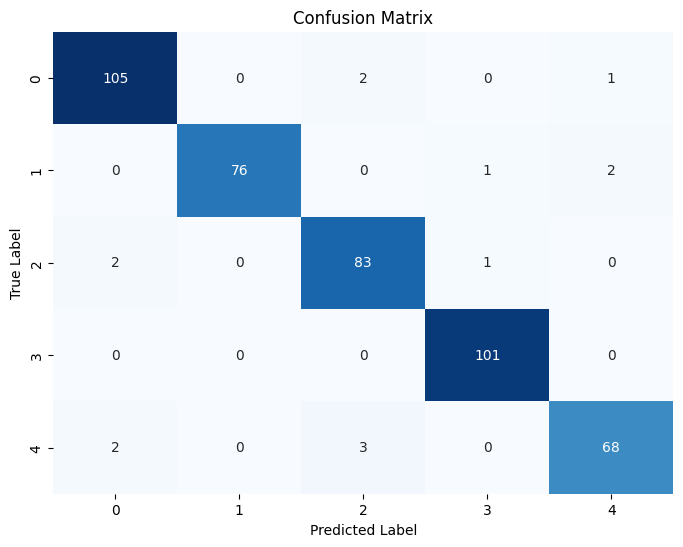

In [66]:
import seaborn as sns
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [67]:
# Vectorize the test data using the trained TF-IDF vectorizer
X_test_tfidf = vectorizer.transform(test_data['Text'])

# Transform the test data using the trained NMF model
X_test_nmf = nmf_model.transform(X_test_tfidf)

# Make predictions on the transformed test data
y_pred_test = classifier.predict(X_test_nmf)

# Create a DataFrame for submission
submission_df = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],  # Assuming 'ArticleId' column exists in test_data
    'Category': y_pred_test
})

# Save the DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)

Conclusion

In conclusion the model was built with a TF-IFD Vector, NMF and a Regression model to predict the category of a text. The best results were achieved with the following hyperparameters which achieved an accuracy score of 0.96868:

hyperparameters:

min_df=2
max_df=0.99

n_components=5
l1_ratio=0
beta_loss='kullback-leibler'

results:

Validation Accuracy: 0.9686800894854586
Precision: 0.9689142315895876
Recall: 0.9686800894854586
F1-score: 0.9686517274087268
Confusion Matrix:
[[105   0   2   0   1]
 [  0  76   0   1   2]
 [  2   0  83   1   0]
 [  0   0   0 101   0]
 [  2   0   3   0  68]]

Key learnings taken away from this analysis was how to analyze text data using TF-IFD Vector and reducing it into two matrices using NMF. I found that the choice in the loss function used to vectorize the the data is very important. Different loss functions are more suitable for different tasks. KL divergence (kullback-leibler) is commonly used in text mining tasks such as topic modeling, where the goal is to extract latent topics from text data while maintaining sparsity and interpretability. Frobenius norm is often used in tasks such as image processing, audio analysis, and recommender systems, where the goal is to approximate a high-dimensional data matrix with a low-rank factorization. I started with Frobenius and saw great gains in accuracy as soon as I switched to KL divergence.

In the future ways to improve could be to explore data augmentation techniques. A more thorough error analysis could also be done to maybe get key takeaways to better improve the model.